In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import itertools
import warnings
warnings.filterwarnings('ignore')

In [4]:
file_path ='/content/drive/MyDrive/shared_FG/CompleteDataset.xlsx'
data = pd.read_excel(file_path)

data.head()


,Label,Area,Spine Density,Number of Primary Dendrite,Number of Secondary Dendrites,Mean Length of primary dendrites,Mean Length of secondary dendrites
0,384-N7 Below,67.550,1.25,5,9,40.71,70.86
1,281-N2 Right,71.208,1.98,7,9,42.10,70.53
2,Green-N1,73.000,1.22,6,8,36.50,92.50
3,Green-N3,84.250,2.68,9,15,40.96,69.38
4,384-N2,89.520,2.84,8,13,49.62,71.60


In [5]:
original_label  = data['Label']
data = data.drop('Label', axis=1)

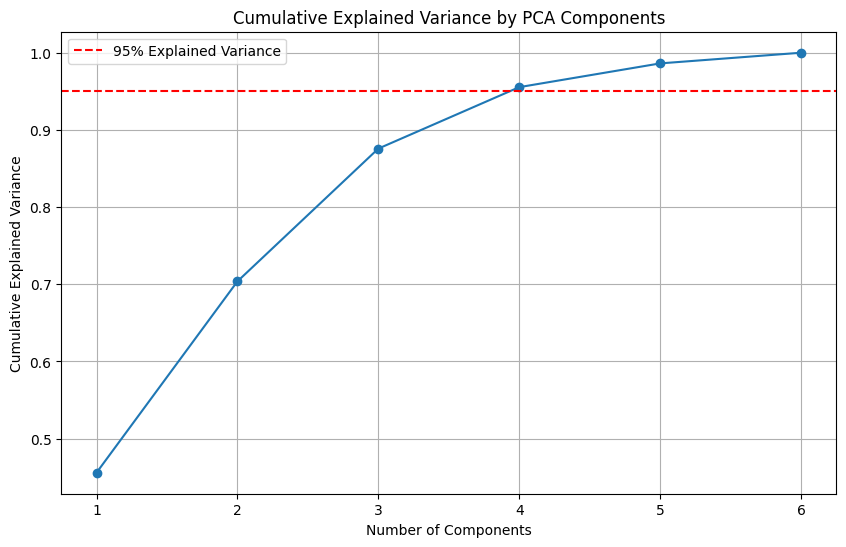

array([0.45574021, 0.70368353, 0.87573765, 0.95538579, 0.98616528,
       1.        ])

In [6]:
scaler = StandardScaler()
neurons_standardized = scaler.fit_transform(data)


pca_full = PCA()
pca_full.fit(neurons_standardized)

# Plot the cumulative explained variance as a function of the number of components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1), np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

np.cumsum(pca_full.explained_variance_ratio_)


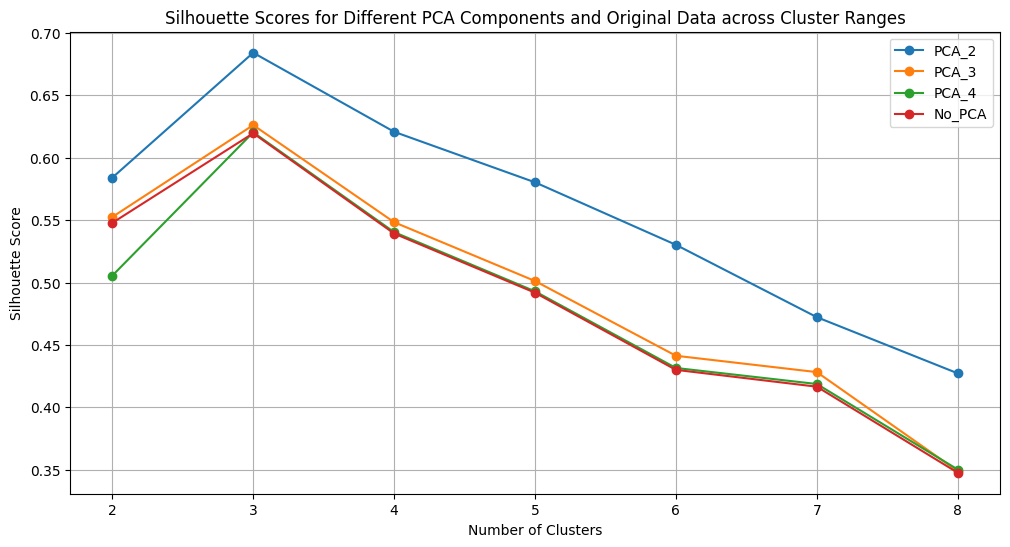

In [7]:
cluster_range = range(2, 9)

# Dictionary to store silhouette scores for each configuration
silhouette_scores_dict = {f'PCA_{n}': [] for n in [2, 3, 4]}
silhouette_scores_dict['No_PCA'] = []

# Apply PCA with different numbers of components and also use the original data where n_components = 'None'
for n_components in [2, 3, 4, None]:
    if n_components is not None:
        pca = PCA(n_components=n_components)
        data_reduced = pca.fit_transform(data)
    else:
        data_reduced = data.values

    # Calculate silhouette scores for different numbers of clusters
    for n_clusters in cluster_range:
        gmm = GaussianMixture(n_components=n_clusters, random_state=42)
        labels = gmm.fit_predict(data_reduced)

        # Calculate and store silhouette score
        score = silhouette_score(data_reduced, labels)
        key = f'PCA_{n_components}' if n_components else 'No_PCA'
        silhouette_scores_dict[key].append(score)

# Plot Silhouette Scores for each PCA configuration and the original data across different cluster numbers
plt.figure(figsize=(12, 6))
for key, scores in silhouette_scores_dict.items():
    plt.plot(cluster_range, scores, marker='o', linestyle='-', label=key)

plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different PCA Components and Original Data across Cluster Ranges')
plt.xticks(cluster_range)
plt.legend()
plt.grid(True)
plt.show()

For n_clusters = 2, init_method = kmeans, silhouette score is 0.41420588418187365
For n_clusters = 2, init_method = random, silhouette score is 0.2120596389702529
For n_clusters = 2, init_method = random_from_data, silhouette score is 0.35577084804857134
For n_clusters = 3, init_method = kmeans, silhouette score is 0.39597712569567706
For n_clusters = 3, init_method = random, silhouette score is 0.22943571192046572
For n_clusters = 3, init_method = random_from_data, silhouette score is 0.153721509082698
For n_clusters = 4, init_method = kmeans, silhouette score is 0.45690190637188294
For n_clusters = 4, init_method = random, silhouette score is 0.2697891272045546
For n_clusters = 4, init_method = random_from_data, silhouette score is 0.1152443650406028
For n_clusters = 5, init_method = kmeans, silhouette score is 0.4185541492609271
For n_clusters = 5, init_method = random, silhouette score is 0.10584840123149475
For n_clusters = 5, init_method = random_from_data, silhouette score is 0.

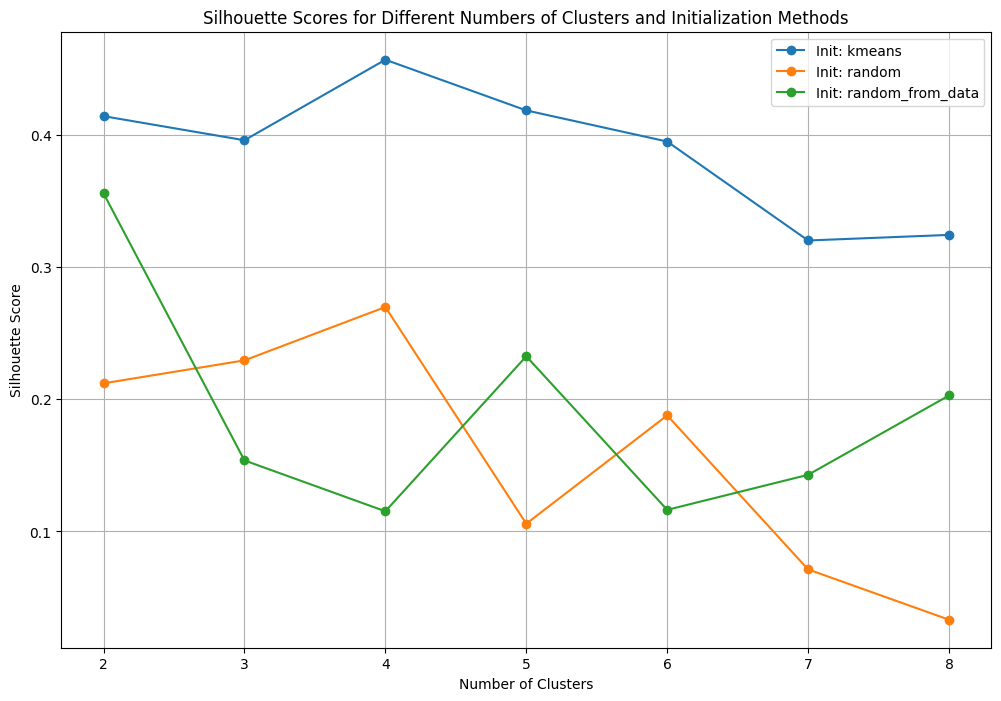

GaussianMixture(n_components=4, random_state=42)

In [8]:
# Tuning the number of clusters and initialization method only

# scale the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Apply PCA
pca = PCA(n_components=4)
data_pca = pca.fit_transform(data_scaled)

# Function to calculate silhouette score
def get_silhouette(data, n_clusters, init_param):
    gmm = GaussianMixture(n_components=n_clusters, init_params=init_param, random_state=42)
    labels = gmm.fit_predict(data)
    silhouette_avg = silhouette_score(data, labels)
    return silhouette_avg

# Parameters to tune
range_n_clusters = list(range(2, 9))
init_methods = ['kmeans', 'random', 'random_from_data']

# List to store all scores
results_list = []

# Perform grid search
for n_clusters in range_n_clusters:
    for init_method in init_methods:
        score = get_silhouette(data_pca, n_clusters, init_method)
        results_list.append({
            'n_clusters': n_clusters,
            'init_method': init_method,
            'silhouette_score': score
        })
        print(f"For n_clusters = {n_clusters}, init_method = {init_method}, silhouette score is {score}")

# Convert list of results to DataFrame
results_df = pd.DataFrame(results_list)

# Find the best model based on silhouette score
best_model = results_df.loc[results_df['silhouette_score'].idxmax()]

print("\nBest model configuration:")
print(best_model)

# Plotting silhouette scores by init_method
plt.figure(figsize=(12, 8))
for method in init_methods:
    subset = results_df[results_df['init_method'] == method]
    plt.plot(subset['n_clusters'], subset['silhouette_score'], marker='o', label=f'Init: {method}')

plt.title('Silhouette Scores for Different Numbers of Clusters and Initialization Methods')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.show()

# Fit GMM with the optimal parameters
best_gmm = GaussianMixture(n_components=int(best_model['n_clusters']),
                           init_params=best_model['init_method'],
                           random_state=42)
best_gmm.fit(data_pca)

In [9]:
# Tuning several GMM parameters

X = data.values

# Apply PCA to reduce dimensions
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)

# Define parameters for tuning
n_components = [2,3,4]
covariance_types = ['spherical', 'diag', 'tied', 'full']
max_iter_grid = [10, 15, 20, 50, 100, 150]
tol_grid = [1e-1, 1e-2, 1e-3, 1e-4]
init_params = ['kmeans', 'random', 'random_from_data']

# List to store all scores
results_list = []

# Perform grid search
for n in n_components:
    for covariance_type in covariance_types:
        for max_iter in max_iter_grid:
            for tol in tol_grid:
                for init in init_params:
                    gmm = GaussianMixture(n_components=n, covariance_type=covariance_type,
                                          max_iter=max_iter, tol=tol, init_params=init, random_state=42)
                    gmm.fit(X_pca)
                    labels = gmm.predict(X_pca)

                    # Compute metrics
                    silhouette = silhouette_score(X_pca, labels)
                    aic = gmm.aic(X_pca)
                    bic = gmm.bic(X_pca)

                    # Record metrics
                    results_list.append({
                        'n_components': n,
                        'covariance_type': covariance_type,
                        'max_iter': max_iter,
                        'tol': tol,
                        'init_params': init,
                        'silhouette_score': silhouette,
                        'aic': aic,
                        'bic': bic
                    })

# Convert list of results to DataFrame
results_df = pd.DataFrame(results_list)

# Find the best models based on different criteria
best_silhouette = results_df.loc[results_df['silhouette_score'].idxmax()]
best_aic = results_df.loc[results_df['aic'].idxmin()]
best_bic = results_df.loc[results_df['bic'].idxmin()]

print("Best model by Silhouette Score:")
print(best_silhouette)
print("\nBest model by AIC:")
print(best_aic)
print("\nBest model by BIC:")
print(best_bic)


Best model by Silhouette Score:
n_components                  3
covariance_type       spherical
max_iter                     10
tol                         0.1
init_params              kmeans
silhouette_score       0.620392
aic                 1202.219169
bic                 1230.058134
Name: 288, dtype: object

Best model by AIC:
n_components                  4
covariance_type            full
max_iter                     10
tol                         0.1
init_params              kmeans
silhouette_score       0.540408
aic                 1052.068177
bic                  1148.68576
Name: 792, dtype: object

Best model by BIC:
n_components                  4
covariance_type            full
max_iter                     10
tol                         0.1
init_params              kmeans
silhouette_score       0.540408
aic                 1052.068177
bic                  1148.68576
Name: 792, dtype: object


In [ ]:
# Fit a GMM to the PCA-reduced data using the optimal parameters (chosen according to AIC, BIC and Silhouette Score)
gmm_params = {
    'n_components': 4,
    'covariance_type': 'full',
    'max_iter': 10,
    'tol': 0.1,
    'random_state': 42
}

gmm = GaussianMixture(**gmm_params)
gmm.fit(X_pca)

# Predict the cluster for each data point
labels = gmm.predict(X_pca)

labels

array([3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2])

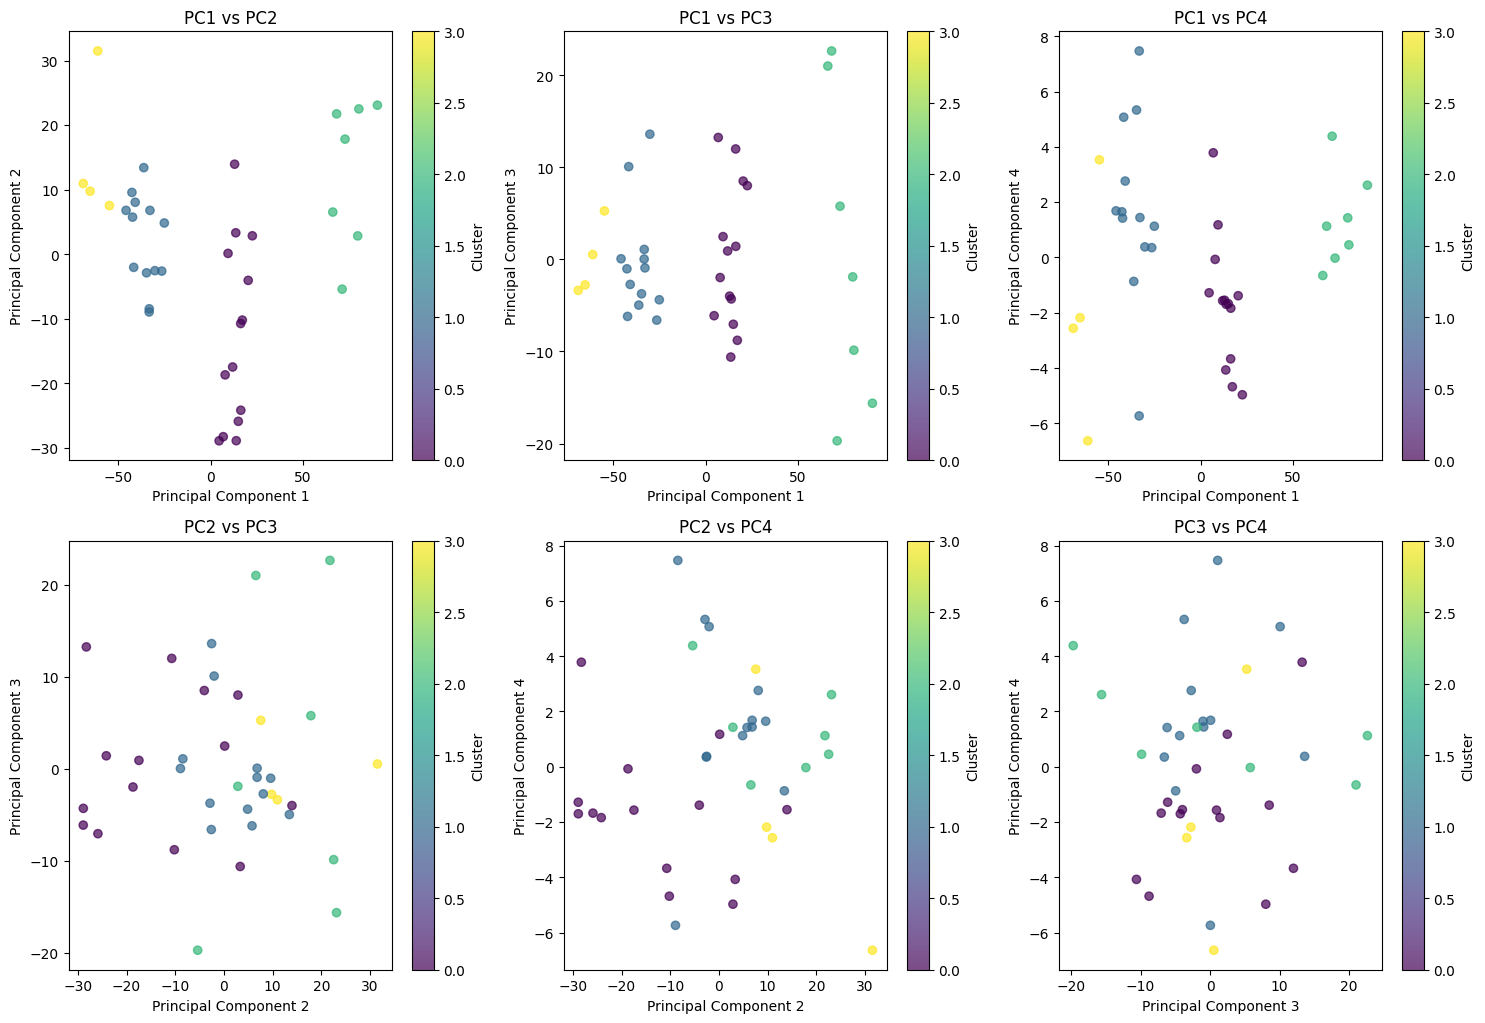

In [ ]:
# Visualize clusters with PCA for all pairs of principal components

# Generate all pairs of principal components
pairs = list(itertools.combinations(range(X_pca.shape[1]), 2))

plt.figure(figsize=(15, 15))
for i, (pc1, pc2) in enumerate(pairs, 1):
    plt.subplot(3, 3, i)
    plt.scatter(X_pca[:, pc1], X_pca[:, pc2], c=labels, cmap='viridis', alpha=0.7)
    plt.title(f'PC{pc1 + 1} vs PC{pc2 + 1}')
    plt.xlabel(f'Principal Component {pc1 + 1}')
    plt.ylabel(f'Principal Component {pc2 + 1}')
    plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()

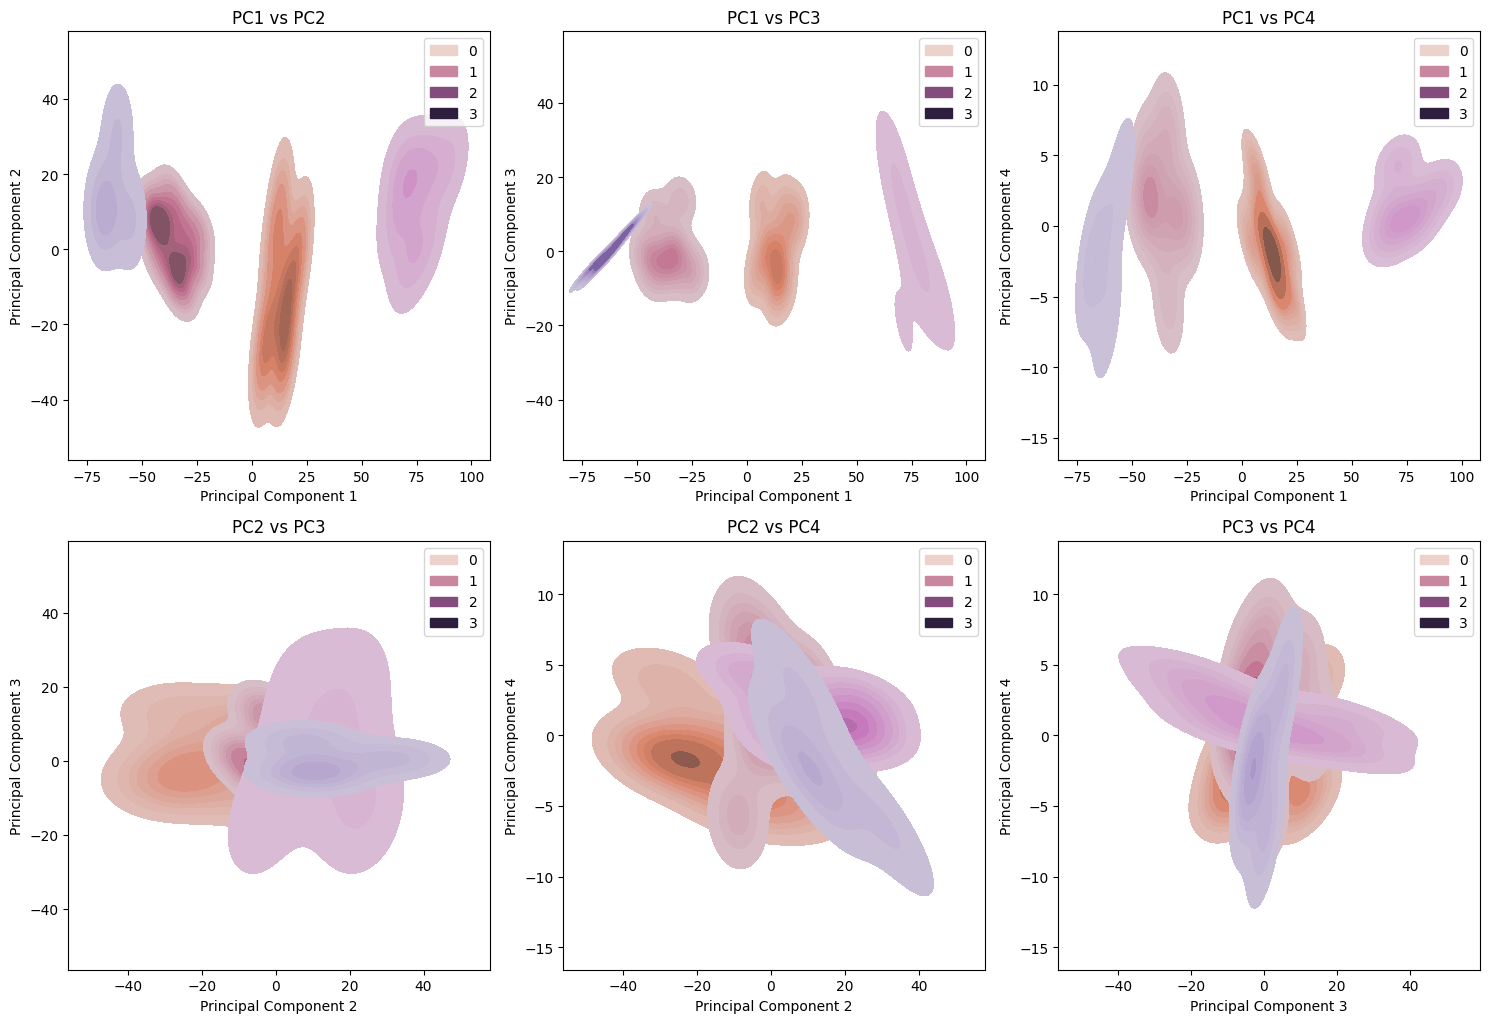

In [ ]:
# Visualize cluster densities with PCA for all pairs of principal components

pairs = list(itertools.combinations(range(X_pca.shape[1]), 2))

plt.figure(figsize=(15, 15))
for i, (pc1, pc2) in enumerate(pairs, 1):
    plt.subplot(3, 3, i)
    sns.kdeplot(x=X_pca[:, pc1], y=X_pca[:, pc2], hue=labels, fill=True)
    plt.title(f'PC{pc1 + 1} vs PC{pc2 + 1}')
    plt.xlabel(f'Principal Component {pc1 + 1}')
    plt.ylabel(f'Principal Component {pc2 + 1}')
plt.tight_layout()
plt.show()


In [ ]:
# Display predicted Cluster Labels along with their respective probablities

# Get the cluster labels for each point
cluster_labels = labels

# Get the probabilities of each point belonging to each cluster
probabilities = gmm.predict_proba(X_pca)

# Calculate the probability of each point belonging to its assigned cluster
max_probabilities = probabilities.max(axis=1)

# Create a DataFrame with the original labels, cluster labels, and probabilities
result_df = pd.DataFrame({
    'Original_Labels': original_label,
    'Cluster_Labels': cluster_labels,
    'Cluster_Probability': max_probabilities
})


In [ ]:
result_df

,Original_Labels,Cluster_Labels,Cluster_Probability
0,384-N7 Below,3,1.000000
1,281-N2 Right,3,1.000000
2,Green-N1,3,1.000000
3,Green-N3,3,0.999993
4,384-N2,1,1.000000
5,Purple 341 - 1,1,1.000000
6,Orange 118 - 2,1,1.000000
7,Purple 341 - 4,1,1.000000
8,Lightblue 210 - 4,1,1.000000
9,Orange 118 - 3,1,1.000000


In [ ]:
#probabilities

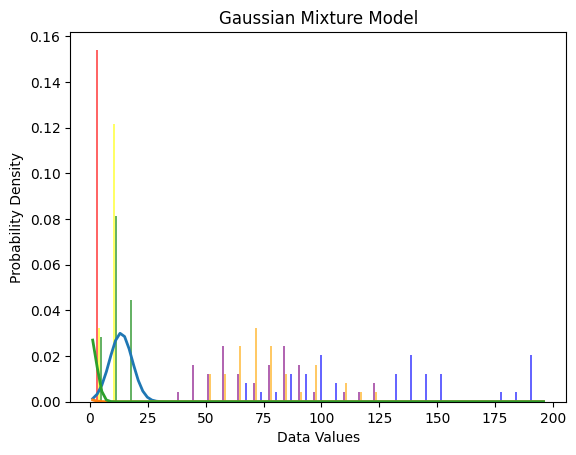

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

# original_label  = data['Label']
# data = data.drop('Label', axis=1)
# Fit a Gaussian mixture model with two components
# gmm = GaussianMixture(n_components=4, random_state=42)
# gmm.fit(data)

# Extract the means, covariances and weights of the Gaussian components
means = gmm.means_.flatten()
covariances = gmm.covariances_.flatten()
weights = gmm.weights_.flatten()

col= ['blue', 'red', 'yellow','green','purple','orange']
# Plot the histogram of the data
plt.hist(data, bins=30, density=True, alpha=0.6, color=col)

# Add the individual Gaussians to the plot
x = np.linspace(np.min(data), np.max(data), 100)
for mean, cov, weight in zip(means, covariances, weights):
    plt.plot(x, weight*norm.pdf(x, mean, np.sqrt(cov)), linewidth=2)

plt.title('Gaussian Mixture Model')
plt.xlabel('Data Values')
plt.ylabel('Probability Density')
plt.show()


GMM tuning number of clusters only with **PCA**

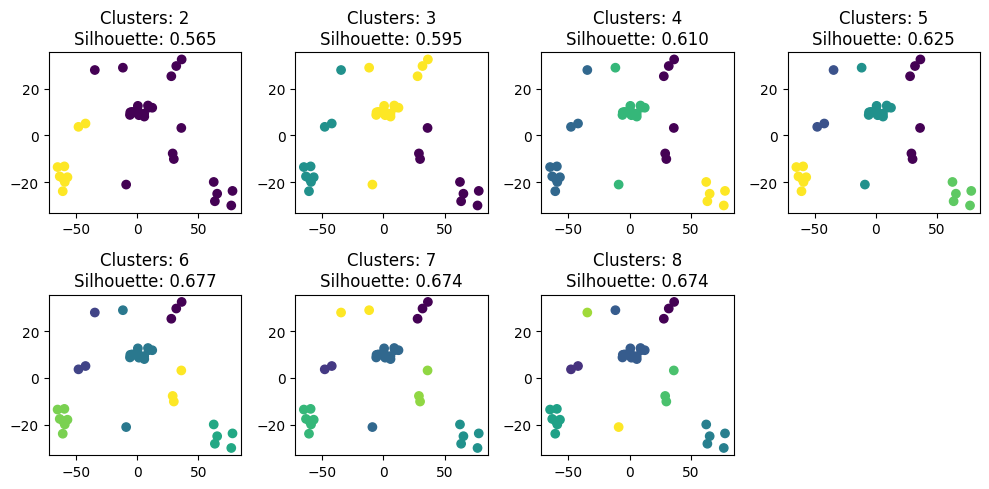

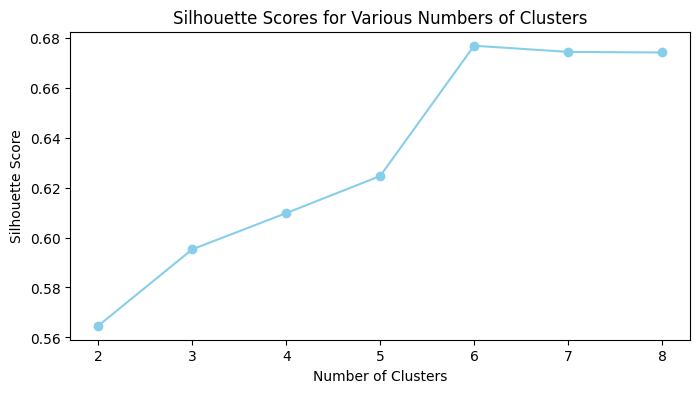

In [ ]:

cluster_labels_df = pd.DataFrame()
# Reduce dimensions for visualization
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(data.values)

# Range of number of components (clusters) to try
n_components_range = range(2, 9)
silhouette_scores = []

plt.figure(figsize=(10, 5))

# Try GMMs using different numbers of components
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    labels = gmm.fit_predict(data_reduced)  # Fit and predict on PCA-reduced data

    cluster_labels_df[f'Cluster_Labels_{n_components}'] = labels

    # Silhouette Score
    score = silhouette_score(data_reduced, labels)
    silhouette_scores.append(score)

    # Plot results
    plt.subplot(2, 4, n_components-1)
    plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=labels, cmap='viridis', marker='o')
    plt.title(f'Clusters: {n_components}\nSilhouette: {score:.3f}')
    plt.tight_layout()

# Plot Silhouette Scores as a line graph
plt.figure(figsize=(8, 4))
plt.plot(range(2, 9), silhouette_scores, marker='o', linestyle='-', color='skyblue')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Various Numbers of Clusters')
plt.xticks(range(2, 9))
plt.show()

#print(cluster_labels_df)


In [ ]:
cluster_labels_df['Original Labels'] = original_label
cluster_labels_df = pd.DataFrame(cluster_labels_df)
cluster_labels_df

,Cluster_Labels_2,Cluster_Labels_3,Cluster_Labels_4,Cluster_Labels_5,Cluster_Labels_6,Cluster_Labels_7,Cluster_Labels_8,Original Labels
0,1,1,1,4,4,4,4,Green 114 - 5
1,1,1,1,4,4,4,4,Blue 243 - 4
2,1,1,1,4,4,4,4,N3_40X_Green490
3,1,1,1,4,4,4,4,Orange 108 - 2
4,1,1,1,4,4,4,4,Green 114 - 4
5,1,1,1,4,4,4,4,Green 114 - 1
6,1,1,1,4,4,4,4,Yellow 505 - 5
7,1,1,1,1,1,1,1,N4_40X_Lilac281
8,1,1,1,1,1,1,1,N2_40X_Green490
9,0,1,1,1,1,6,6,N4_40X_Blue235


GridSearch Tuning for GMM with a fixed number of clusters k = 6

In [ ]:
# Assuming 'data' is your DataFrame and you have already dropped the 'Label' column
X = data.values

# Apply PCA to reduce to two dimensions for GMM
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# given that we chose the number of clusters based on tuning the number of clusters only
n_components = [5,6,7]
covariance_types = ['spherical', 'diag', 'tied', 'full']
max_iter_grid = [20, 50, 100, 150]
tol_grid = [100, 10, 1, 1e-1, 1e-2, 1e-3, 1e-4]

# List to store all scores
results_list = []

# Perform grid search
for n in n_components:
  for covariance_type in covariance_types:
        for max_iter in max_iter_grid:
            for tol in tol_grid:
                gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type,
                                      max_iter=max_iter, tol=tol, random_state=42)
                gmm.fit(X_pca)
                labels = gmm.predict(X_pca)

                # Compute metrics
                silhouette = silhouette_score(X_pca, labels)
                aic = gmm.aic(X_pca)
                bic = gmm.bic(X_pca)

                # Record metrics
                results_list.append({
                    'n_components': n_components,
                    'covariance_type': covariance_type,
                    'max_iter': max_iter,
                    'tol': tol,
                    'silhouette_score': silhouette,
                    'aic': aic,
                    'bic': bic
                })

# Convert list of results to DataFrame
results_df = pd.DataFrame(results_list)

# Find the best models based on different criteria
best_silhouette = results_df.loc[results_df['silhouette_score'].idxmax()]
best_aic = results_df.loc[results_df['aic'].idxmin()]
best_bic = results_df.loc[results_df['bic'].idxmin()]

print("Best model by Silhouette Score:")
print(best_silhouette)
print("\nBest model by AIC:")
print(best_aic)
print("\nBest model by BIC:")
print(best_bic)


Best model by Silhouette Score:
n_components                 6
covariance_type      spherical
max_iter                    20
tol                      100.0
silhouette_score      0.676845
aic                 612.905344
bic                  649.32628
Name: 0, dtype: object

Best model by AIC:
n_components                 6
covariance_type           full
max_iter                    20
tol                      100.0
silhouette_score      0.676845
aic                 603.845302
bic                 659.268465
Name: 84, dtype: object

Best model by BIC:
n_components                 6
covariance_type      spherical
max_iter                    20
tol                      100.0
silhouette_score      0.676845
aic                 612.905344
bic                  649.32628
Name: 0, dtype: object


The Bayesian Information Criterion (BIC) is more useful in selecting a correct model while the AIC is more appropriate in finding the best model for predicting future observations.

Decide on which model?

Fitting the best model

Best model by BIC

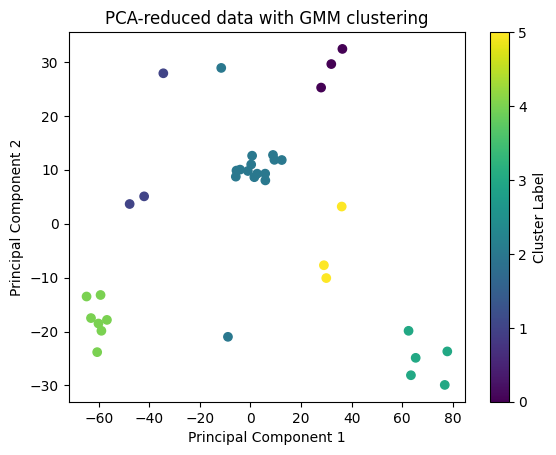

In [ ]:
# Assuming 'data' is your DataFrame and the 'Label' column has been dropped
X = data.values

# Apply PCA to reduce to two dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Fit a GMM to the PCA-reduced data
gmm_params = {
    'n_components': 6,
    'covariance_type': 'spherical',
    'max_iter': 20,
    'tol': 100,
    'random_state': 42
}

gmm = GaussianMixture(**gmm_params)
gmm.fit(X_pca)

# Predict the cluster for each data point
labels = gmm.predict(X_pca)

# Visualize the results
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.title('PCA-reduced data with GMM clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


<ipython-input-8-f6db299edf53>:32: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(mpatches.Ellipse(position, nsig * width, nsig * height,


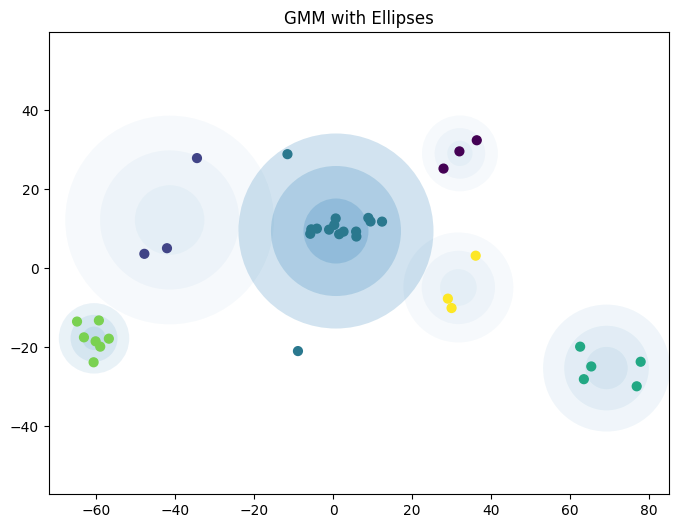

Log-likelihood: -7.873685333865776
AIC: 612.9053440383359
BIC: 649.3262796228264


In [ ]:
import matplotlib.patches as mpatches

# Plot with ellipses
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')

    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor, ax=ax)

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width = height = 2 * np.sqrt(covariance) if np.isscalar(covariance) else 2 * np.sqrt(np.diag(covariance))

    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(mpatches.Ellipse(position, nsig * width, nsig * height,
                                      angle, **kwargs))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_gmm(gmm, X_pca, ax=ax)
plt.title('GMM with Ellipses')
plt.show()

# Print model diagnostics
print(f"Log-likelihood: {gmm.score(X_pca)}")
print(f"AIC: {gmm.aic(X_pca)}")
print(f"BIC: {gmm.bic(X_pca)}")


Histogram for number of components in each cluster

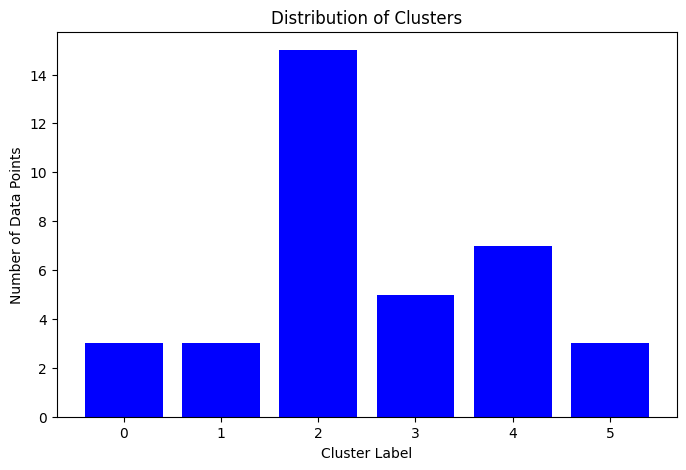

In [ ]:
# Assuming 'labels' are the cluster labels from the GMM
plt.figure(figsize=(8, 5))
plt.hist(labels, bins=np.arange(0, gmm.n_components + 1) - 0.5, rwidth=0.8, color='blue')
plt.title('Distribution of Clusters')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Data Points')
plt.xticks(np.arange(gmm.n_components))
plt.show()



Density Plot of Each Cluster

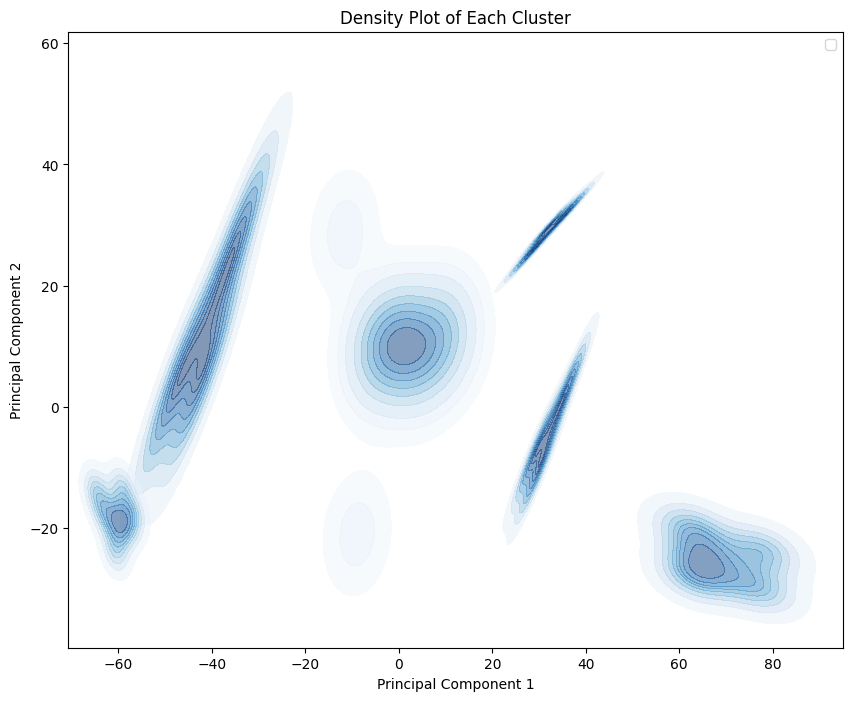

In [ ]:
# Create a DataFrame from the PCA-reduced data
df_pca = pd.DataFrame(data_reduced, columns=['Component 1', 'Component 2'])
df_pca['Cluster'] = labels  # Add cluster labels

# Plot density of each cluster
plt.figure(figsize=(10, 8))
for i in range(gmm.n_components):
    # Corrected seaborn kdeplot call
    sns.kdeplot(x=df_pca[df_pca['Cluster'] == i]['Component 1'],
                y=df_pca[df_pca['Cluster'] == i]['Component 2'],
                cmap="Blues", fill=True, alpha=0.5, label=f'Cluster {i}')
plt.title('Density Plot of Each Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

Getting the probablities of a point being in the cluster

In [ ]:
# Get the probabilities for each point belonging to each cluster
probabilities = gmm.predict_proba(X_pca)

# Add the maximum probability for each point to the original DataFrame
df_pca['Max_Probability'] = probabilities.max(axis=1)

# Show the first few entries
print(df_pca.head())

   Component 1  Component 2  Cluster  Max_Probability
0   -64.853500   -13.502889        4         0.999843
1   -63.101620   -17.501821        4         0.999988
2   -60.654427   -23.817354        4         0.999992
3   -60.146413   -18.509848        4         0.999988
4   -59.316967   -13.221192        4         0.999668


In [ ]:
# Select the probability of the assigned cluster for each point
assigned_cluster_probabilities = probabilities[np.arange(len(labels)), labels]

# Add this probability to the DataFrame
df_pca['Assigned_Cluster_Probability'] = assigned_cluster_probabilities

# Show the DataFrame with the new column
df_pca = pd.DataFrame(df_pca)
df_pca

,Component 1,Component 2,Cluster,Max_Probability,Assigned_Cluster_Probability
0,-64.853500,-13.502889,4,0.999843,0.999843
1,-63.101620,-17.501821,4,0.999988,0.999988
2,-60.654427,-23.817354,4,0.999992,0.999992
3,-60.146413,-18.509848,4,0.999988,0.999988
4,-59.316967,-13.221192,4,0.999668,0.999668
5,-58.980331,-19.859470,4,0.999987,0.999987
6,-56.794814,-17.840329,4,0.999930,0.999930
7,-47.804043,3.647497,1,1.000000,1.000000
8,-42.074633,5.067901,1,0.999991,0.999991
9,-34.480335,27.888551,1,0.999672,0.999672


In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Create histograms with KDE for each cluster along both principal components
# fig, axes = plt.subplots(2, 1, figsize=(12, 16))

# # Plot for the first principal component
# for i in range(gmm.n_components):
#     cluster_data = df_pca[df_pca['Cluster'] == i]['Component 1']
#     sns.histplot(cluster_data, bins=20, kde=True, stat="density", linewidth=0, color=sns.color_palette("Set2")[i], ax=axes[0])
#     sns.kdeplot(cluster_data, color=sns.color_palette("Set2")[i], label=f'Cluster {i}', ax=axes[0])

# axes[0].set_title('Histogram and KDE of Each Cluster along Principal Component 1')
# axes[0].set_xlabel('Principal Component 1')
# axes[0].set_ylabel('Density')

# # Plot for the second principal component
# for i in range(gmm.n_components):
#     cluster_data = df_pca[df_pca['Cluster'] == i]['Component 2']
#     sns.histplot(cluster_data, bins=20, kde=True, stat="density", linewidth=0, color=sns.color_palette("Set2")[i], ax=axes[1])
#     sns.kdeplot(cluster_data, color=sns.color_palette("Set2")[i], label=f'Cluster {i}', ax=axes[1])

# axes[1].set_title('Histogram and KDE of Each Cluster along Principal Component 2')
# axes[1].set_xlabel('Principal Component 2')
# axes[1].set_ylabel('Density')

# plt.legend()
# plt.tight_layout()
# plt.show()


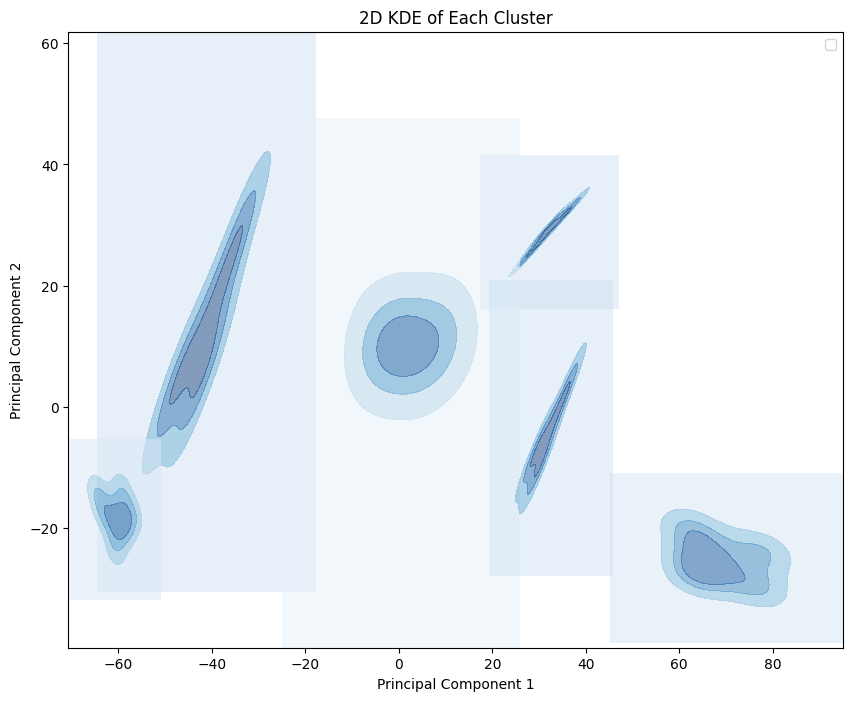

In [ ]:
import seaborn as sns

# Create a DataFrame from the PCA-reduced data
df_pca = pd.DataFrame(data_reduced, columns=['Component 1', 'Component 2'])
df_pca['Cluster'] = labels  # Add cluster labels

# Plot 2D KDE for each cluster
plt.figure(figsize=(10, 8))
for i in range(gmm.n_components):
    # Filter the data for the current cluster
    cluster_data = df_pca[df_pca['Cluster'] == i]
    # Plot 2D KDE
    sns.kdeplot(x=cluster_data['Component 1'], y=cluster_data['Component 2'],
                levels=5, cmap="Blues", fill=True, thresh=0, alpha=0.5, label=f'Cluster {i}')
plt.title('2D KDE of Each Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


visualizing the means and covariance ellipses of the clusters in a 2D plot

IndexError: invalid index to scalar variable.

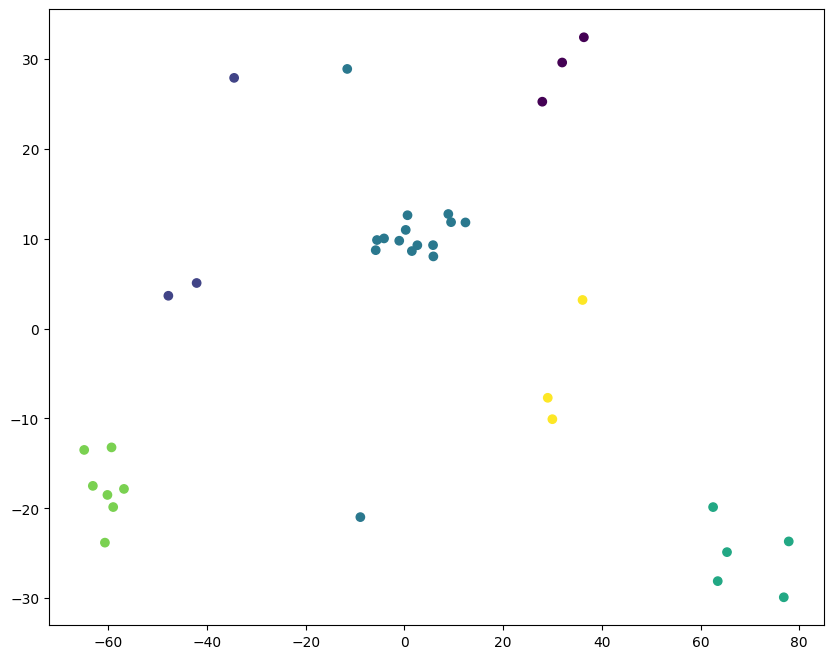

In [ ]:

# Assume X_pca is the PCA-reduced data and gmm is the fitted GaussianMixture model
plt.figure(figsize=(10, 8))

# Scatter plot of the reduced data
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')

# Plot ellipses for each Gaussian component
for mean, covariance in zip(gmm.means_, gmm.covariances_):
    # Get the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(covariance[:2, :2])
    # Compute the angle between the first eigenvector and the x-axis
    angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    # Normalize the eigenvalues to determine the ellipse size
    width, height = 2 * np.sqrt(eigenvalues)
    # Create the ellipse patch
    ellipse = mpatches.Ellipse(mean[:2], width, height, angle=angle, alpha=0.5, color='red')
    plt.gca().add_patch(ellipse)

# Label the axes
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Means and Covariances')
plt.show()


**WITHOUT PCA**